## Sentiment Classification

In this project, we train, validate (to fine tune) and test (final hold-out set) a simple [BOW](https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/) text classifier on a review dataset.

In [1]:
#!pip install xgboost
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

The reviews were web scraped from [TrustPilot](https://www.trustpilot.com/). There will be a future project shared on how it can be done. Keep in mind to review and follow web scraping best practices and your own judgement while doing web scraping projects.

In [2]:
data = pd.read_csv('PupSocks.csv', delimiter=',', error_bad_lines=False)

In [3]:
print(len(data))

6040


In [4]:
print(data.columns)

Index(['Name', 'DatePublished', 'RatingValue', 'Review'], dtype='object')


We perform train_test split twice to get 3 datasets - first gives split dataset which will be further split into model(60%) and validation(20%) datasets and other is final (unseen-20%) test dataset.

In [5]:
# Train Test Split Function

def split_train_test(data, test_size, shuffle_state, train_file, test_file):
    train, test= train_test_split(data, shuffle=shuffle_state, test_size=test_size, random_state=15)
    #save the data
    train.to_csv(train_file)
    test.to_csv(test_file)

# Call the train_test_split
split_train_test(data,0.20,True,'split.csv','test.csv')

# load the split data
split_data = pd.read_csv('split.csv', error_bad_lines=False)
# load the test data
test_data = pd.read_csv('test.csv', error_bad_lines=False)

In [6]:
print(len(split_data))
print(len(test_data))

4832
1208


In [7]:
# Call the train_test_split
split_train_test(split_data, 0.25,True,'model.csv','valid.csv')

#load the model data
model_data = pd.read_csv('model.csv', error_bad_lines=False)
# load the validation data
valid_data = pd.read_csv('valid.csv', error_bad_lines=False)

In [8]:
print(len(model_data))
print(len(valid_data))

3624
1208


Ratings are typically binned into negative (ratings 1 & 2), neutral (rating 3) and positive (ratings 4 & 5) as done here. Also, we can see that the data is imbalanced.

Number of rows per star rating:
1    1580
5    1175
2     355
3     261
4     253
Name: RatingValue, dtype: int64


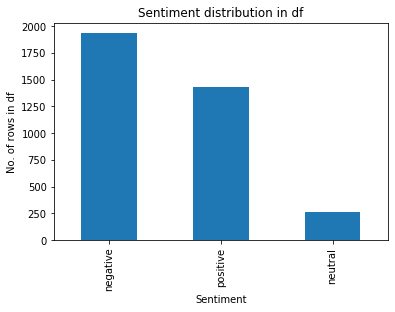

In [9]:
print("Number of rows per star rating:")
print(model_data['RatingValue'].value_counts())

# Function to map rating to sentiment
def map_sentiment(rating_received):
    if rating_received <= 2:
        return "negative"
    elif rating_received == 3:
        return "neutral"
    else:
        return "positive"

# Mapping rating to sentiment into three categories
model_data['sentiment'] = [ map_sentiment(x) for x in model_data['RatingValue']]
valid_data['sentiment'] = [ map_sentiment(x) for x in valid_data['RatingValue']]
test_data['sentiment'] = [ map_sentiment(x) for x in test_data['RatingValue']]

# Plotting the sentiment distribution for model_data
plt.figure()
pd.value_counts(model_data['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

We balance the model data, this can be done in many ways. Most simple is to drop positive and negative reviews to match neutral review numbers but that will leave us with very few data points to train the model well. Here we create new neutral reviews by replacement to balance the data. We start with equal numbers for all 3 groups, say 1000 each, later based on results from validation dataset, we fine tune this number for each sentiment group. 

This balancing could be done before the splitting, but that would have either left us with very few observations (if we matched neutral) or introduced bias in validation and/or test datasets if we'd imputed neutral with replacement.

1935 1428 261
After segregating and taking equal (somewhat, as fine tuned afterwards) number of rows for each sentiment:
neutral     1000
negative     900
positive     800
Name: sentiment, dtype: int64
Number of rows per star rating:
3    1000
1     737
5     642
2     163
4     158
Name: RatingValue, dtype: int64


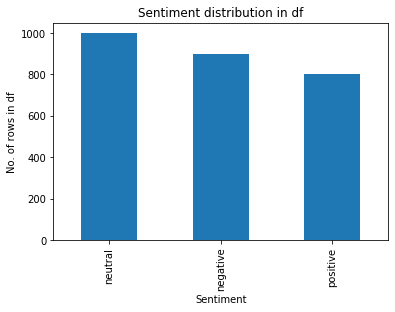

In [24]:
# Function to retrieve top few number of each category
def get_sample_data():
    data_positive = model_data[model_data['sentiment'] == "positive"].sample(800)
    data_negative = model_data[model_data['sentiment'] == "negative"].sample(900)
    data_neutral = model_data[model_data['sentiment'] == "neutral"].sample(1000, replace=True)
    train_data = pd.concat([data_positive, data_negative, data_neutral])
    return train_data

p_count, nu_count, ne_count = model_data['sentiment'].value_counts()
print(p_count, nu_count, ne_count)
# Function call to get the random number of reviews from each sentiment
train_data = get_sample_data()

# After selecting samples of each sentiment
print("After segregating and taking equal (somewhat, as fine tuned afterwards) number of rows for each sentiment:")
print(train_data['sentiment'].value_counts())

# Plotting the sentiment distribution
print("Number of rows per star rating:")
print(train_data['RatingValue'].value_counts())

plt.figure()
pd.value_counts(train_data['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

We build a basic pipeline to vectorize, transform and classify the text data. We use CountVectorizer to convert reviews into a matrix of token counts (word frequency per document/review) and to build a vocabulary of words, basically a BOW. Then we transform the raw counts to [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighted values using TfidfTransformer. This helps provide weightage to words appearing in each document keeping in mind how often a word appears in all documents, hence indicating how important a word is to a particular document (in turn review-sentiment). In the end, we use a classifier. We can try a few different classifiers to see which performs best. Boosted trees (XGB) itself are known to be pretty good to extract feature importance. We can skip TF-IDF step to experiment what gives best results. In additiom (refer to [hyperparameter tuning](https://github.com/kanwarpreet11/MNIST_CNN) project), we can try to include and fine tune other parameters too, to see what gives best accuracy. 

This is a traditional ML approach to text classification. We can also explore deep learning - neural language models to implement the classification task to compare what works best (might upload a neural model project later).

Only need to run one of the below 3 classifier before training the model (finally, XGB was used to train the model)-

In [25]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=0.01, random_state=42,
                          max_iter=5, tol=None)),
])

In [37]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', XGBClassifier(verbosity = 0)),
])

In [33]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])

Train the model on training dataset

In [38]:
### Train the model
text_clf.fit(train_data.Review, train_data.sentiment)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=0)

We evaluate the trained model on validation set and then choose best performing classifier, sample data values (while balancing) and any other parameters we want to experiment with.

In [39]:
#Evaluate the model on validation dataset
predicted = text_clf.predict(valid_data.Review)

In [40]:
print(classification_report(valid_data.sentiment, predicted))
print("accuracy:",accuracy_score(valid_data.sentiment, predicted))
print("f1-score:",f1_score(valid_data.sentiment, predicted, average=None))

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89       652
     neutral       0.40      0.43      0.41       108
    positive       0.87      0.88      0.88       448

    accuracy                           0.84      1208
   macro avg       0.72      0.73      0.73      1208
weighted avg       0.84      0.84      0.84      1208

accuracy: 0.8394039735099338
f1-score: [0.88613478 0.41071429 0.87902331]


In [41]:
confusion_matrix = pd.crosstab(valid_data.sentiment, predicted, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion_matrix:\n",confusion_matrix)


Confusion_matrix:
 Predicted  negative  neutral  positive
Actual                                
negative        572       47        33
neutral          38       46        24
positive         29       23       396


**After doing all finetuning, we evaluate the final model on the unseen test dataset. Overall accuracy didn't drop (actually improved), so seems we have generalized the model well. Though, overall accuracy is decent, accuracy for neutral is not impressive which is typical as it's difficult for any classification model to segregate borderline cases, especially with less number of sample data from an imbalanced dataset.**

In [42]:
#Evaluate the model on test_data
predicted = text_clf.predict(test_data.Review)

In [43]:
print(classification_report(test_data.sentiment, predicted))
print("accuracy:",accuracy_score(test_data.sentiment, predicted))
print("f1-score:",f1_score(test_data.sentiment, predicted, average=None))

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89       608
     neutral       0.32      0.37      0.34       104
    positive       0.91      0.89      0.90       496

    accuracy                           0.84      1208
   macro avg       0.71      0.71      0.71      1208
weighted avg       0.85      0.84      0.85      1208

accuracy: 0.8427152317880795
f1-score: [0.8920033  0.34234234 0.8950051 ]


In [44]:
confusion_matrix = pd.crosstab(test_data.sentiment, predicted, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion_matrix:\n",confusion_matrix)


Confusion_matrix:
 Predicted  negative  neutral  positive
Actual                                
negative        541       44        23
neutral          43       38        23
positive         21       36       439
